# Replaying Parts of a Simulation

When simulating a bio-realistic network, cells will recieve synaptic stimulation from both locally recurrent connections as-well-as feedforward connections from external inputs. Often when analyzing the results of a full network activity we would like to know the contribution of only a subset of the synaptic activity. For example, how much does the feedforward synapses, or only recurrent synapses between specific population of cells, contributed to the simulation results. Certain techniques, like running with only a subset of the full network, or using optogenetic/current-clamping to turn on-off subpoluations, can provide useful insights but also not tell the full story of a network simulation.

Instead we can used the BMTK "replay" input module to disentangle subsections of a simulation activity from the full network in BioNet/biophysically realistic simulations. The BMTK "replay" module let's the user take a previous simulation, and replay a simulation but using only activity for only a subset of the synapses. This can be helpful in parameter tuning and optimization, and for very large networks can provide an efficient manner to replay small subsets of a full network.

<div>
<img src="_static/_tutorial_images/disconnected_sim_figure.png" width="700"/>
</div>

In [1]:
from bmtk.simulator import bionet
from bmtk.analyzer.spike_trains import plot_raster

## Initial Simulation (Generating a Baseline for Synaptic Activity)

First step is to take an existing network + simulation or build one from scratch. For more information on how to build and run BioNet simulations please see existing [tutorials](https://alleninstitute.github.io/bmtk/tutorials.html). For our example we copy the [bionet_450cell example network](https://github.com/AllenInstitute/bmtk/tree/develop/examples/bio_450cells), although any network that is synaptically stimulated will work. 

We will run the full network once and save the spike-trains file (see "**outputs**" section in *config.simulation.json*) under *previous_results/spikes.baseline.h5*. This baseline spike-train file will be used when replaying the simulation using only subset of the full set of synapses.

In [2]:
conf = bionet.Config.from_json('bio_disconnected_sims/config.simulation.json')
conf.build_env()

net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

2023-01-11 14:45:04,875 [INFO] Created log file
2023-01-11 14:45:05,001 [INFO] Building cells.
2023-01-11 14:45:26,161 [INFO] Building recurrent connections
2023-01-11 14:45:31,537 [INFO] Building virtual cell stimulations for external_spikes
2023-01-11 14:45:32,240 [INFO] Running simulation for 2000.000 ms with the time step 0.100 ms
2023-01-11 14:45:32,241 [INFO] Starting timestep: 0 at t_sim: 0.000 ms
2023-01-11 14:45:32,241 [INFO] Block save every 5000 steps
2023-01-11 14:45:56,556 [INFO]     step:5000 t_sim:500.00 ms
2023-01-11 14:46:21,101 [INFO]     step:10000 t_sim:1000.00 ms
2023-01-11 14:46:45,735 [INFO]     step:15000 t_sim:1500.00 ms
2023-01-11 14:47:11,577 [INFO]     step:20000 t_sim:2000.00 ms
2023-01-11 14:47:11,600 [INFO] Simulation completed in 99.36 seconds 


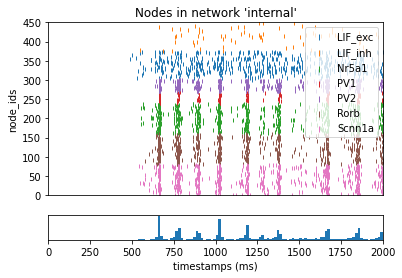

In [3]:
_ = plot_raster(config_file='bio_disconnected_sims/config.simulation.json', group_by='model_name')

## Simulation with Only Feedforward (Virtual) Synaptic Activity.

One useful method for analyzing a full network is to run a simulation with only feedforward virtual networks without any recurrent connections. The network will be still be driven by virtual (pre-defined) spike inputs into the synapses our primary contingent of cells, but the local cell-to-cell connectivity will be removed. This way we can see how much of our network is driven purely by the outside stimulation.

To run a simulation with virtual stimulation only we only need to edit the "networks" section of our simulation configuration to exclude the recurrent connectivity. Here we make a copy of *config.simulation.json* which we'll name "*config.simulation_feedforward.json*" and update the "networks" sections to remove the recurrent (*internal_internal_edges* files) connections:

```json
{
  "networks": {
    "nodes": [
      {
        "nodes_file": "$NETWORK_DIR/internal_nodes.h5",
        "node_types_file": "$NETWORK_DIR/internal_node_types.csv"
      },
      {
        "nodes_file": "$NETWORK_DIR/external_nodes.h5",
        "node_types_file": "$NETWORK_DIR/external_node_types.csv"
      }
    ],
    "edges": [
      {
        "edges_file": "$NETWORK_DIR/external_internal_edges.h5",
        "edge_types_file": "$NETWORK_DIR/external_internal_edge_types.csv"
      }
    ]
  }
}
```

Also just so we don't overwrite our previous output we can update the "output" folder where spikes are stored:
```json
{
  "output": {
    "output_dir": "$BASE_DIR/output_feedforward",
    "log_file": "log.txt",
    "spikes_file": "spikes.h5"
  }
}
```

Then we can rerun the simulation with feedforward only and plot the results

In [4]:
bionet.reset()

conf = bionet.Config.from_json('bio_disconnected_sims/config.simulation_feedforward.json')
conf.build_env()

net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

2023-01-11 14:47:11,973 [INFO] Created log file
Mechanisms already loaded from path: /local1/workspace/bmtk/docs/tutorial/bio_disconnected_sims/components/mechanisms.  Aborting.
2023-01-11 14:47:12,004 [INFO] Building cells.
2023-01-11 14:48:16,629 [INFO] Building recurrent connections
2023-01-11 14:48:16,870 [INFO] Building virtual cell stimulations for external_spikes
2023-01-11 14:48:18,247 [INFO] Running simulation for 2000.000 ms with the time step 0.100 ms
2023-01-11 14:48:18,248 [INFO] Starting timestep: 0 at t_sim: 0.000 ms
2023-01-11 14:48:18,249 [INFO] Block save every 5000 steps
2023-01-11 14:48:59,110 [INFO]     step:5000 t_sim:500.00 ms
2023-01-11 14:49:40,297 [INFO]     step:10000 t_sim:1000.00 ms
2023-01-11 14:50:21,635 [INFO]     step:15000 t_sim:1500.00 ms
2023-01-11 14:51:03,666 [INFO]     step:20000 t_sim:2000.00 ms
2023-01-11 14:51:03,691 [INFO] Simulation completed in 2.0 minutes, 45.44 seconds 


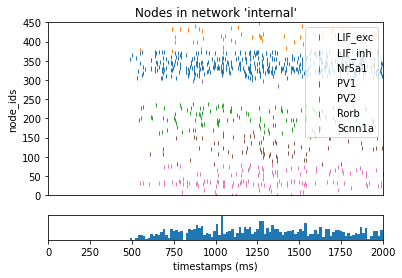

In [5]:
_ = plot_raster(config_file='bio_disconnected_sims/config.simulation_feedforward.json', group_by='model_name')

Next we would like to see the contributions the recurrently connectivity had on the simulation. Unlike before we can't just run a simulation with recurrent only connections and no external stimuli. Luckily, we can utilized the previous simulation results saved in the *previous_results/spikes.baseline.h5* and the "**replay**" module in BioNet to rerun a simulation with recurrent only activity acting up our cells.

## Simulations with Only Recurrent Synpatic Activity.

Using the previous full simulation output *spikes.baseline.h5* spike-train file, we now want to re-run a simulation to see the contributions of only recurrent activity had on the total output of the simulation. To do so we just have to make changes to the json configuration files.

First step is to make a copy of the *config.simulation.json* file, which we'll rename to *config.simulation_recurrent.json*, then updat the following sections


Since we don't want feedforward virtual stimuli we can remove the *external* nodes and edges files from the "**networks**" section 
```json
{
  "networks": {
    "nodes": [
      {
        "nodes_file": "$NETWORK_DIR/internal_nodes.h5",
        "node_types_file": "$NETWORK_DIR/internal_node_types.csv"
      }
    ]
  }
}
```
 
For good measure we also want to update the "**output**" section so that we save the new recurrent-only simulation in a different folder:
```json
{
  "output":{
    "output_dir": "$BASE_DIR/output_recurrent",
    "log_file": "log.txt",
    "spikes_file": "spikes.h5"
  }
}
```


And most importantly, we modify the "**inputs**" to tell BioNet to use the `replay` module:

```json
{
  "inputs": {
    "replay_spikes": {
      "input_type": "replay_spikes",
      "module": "replay",
      "spikes_file": "$BASE_DIR/previous_results/spikes.baseline.h5",
      "edges": {
        "edges_file": "$NETWORK_DIR/internal_internal_edges.h5",
        "edge_types_file": "$NETWORK_DIR/internal_internal_edge_types.csv"
      }
    }
  }
}
```
* `replay_spikes` is the name of the module and which can be set to whatever value is most descriptive for our situation.
* `input_type` and `module` will always need to be set to `replay_spikes` and `replay`, respectively
* `spikes_file` is the name of some previous simulation which BioNet will use to spontaneously determine when recurrent synapses are activated.
* `edges` are the edge/edge-type SONATA files containing recurrent connections.


Now we can re-run the simulation and plot the contributions of the recurrent synaptic activity to the full simulation:

In [6]:
bionet.reset()

conf = bionet.Config.from_json('bio_disconnected_sims/config.simulation_recurrent.json')
conf.build_env()

net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

2023-01-11 14:51:04,025 [INFO] Created log file
Mechanisms already loaded from path: /local1/workspace/bmtk/docs/tutorial/bio_disconnected_sims/components/mechanisms.  Aborting.
2023-01-11 14:51:04,042 [INFO] Building cells.
2023-01-11 14:52:45,049 [INFO] Building recurrent connections
2023-01-11 14:52:45,414 [INFO] Building replay connections "replay_spikes"
2023-01-11 14:52:49,981 [INFO] Running simulation for 2000.000 ms with the time step 0.100 ms
2023-01-11 14:52:49,982 [INFO] Starting timestep: 0 at t_sim: 0.000 ms
2023-01-11 14:52:49,983 [INFO] Block save every 5000 steps
2023-01-11 14:53:39,383 [INFO]     step:5000 t_sim:500.00 ms
2023-01-11 14:54:28,811 [INFO]     step:10000 t_sim:1000.00 ms
2023-01-11 14:55:18,110 [INFO]     step:15000 t_sim:1500.00 ms
2023-01-11 14:56:08,024 [INFO]     step:20000 t_sim:2000.00 ms
2023-01-11 14:56:08,053 [INFO] Simulation completed in 3.0 minutes, 18.07 seconds 


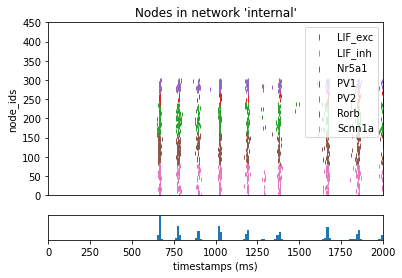

In [7]:
_ = plot_raster(config_file='bio_disconnected_sims/config.simulation_recurrent.json', group_by='model_name')

#### Recreating the Whole (Validation of Synaptic Activity Summation) 

Now that we can show to contribution of feedforward only synaptic activity, and recurrent only synapstic activity, we might expect the two to sum up to the full simulation activity. Indeed we can combine the feedforward inputs with the recurrent replay inputs, which we will do in a new configuration file *config.simulation_recreated.json*

```json
{
  "inputs": {
    "replay_spikes": {
      "input_type": "replay_spikes",
      "module": "replay",
      "spikes_file": "$BASE_DIR/previous_results/spikes.baseline.h5",
      "edges": {
        "edges_file": "$NETWORK_DIR/internal_internal_edges.h5",
        "edge_types_file": "$NETWORK_DIR/internal_internal_edge_types.csv"
      }
    },

    "external_spikes": {
      "input_type": "spikes",
      "module": "sonata",
      "input_file": "$INPUT_DIR/external_spikes.h5",
      "node_set": "external"
    }
  }
}
```

And when we run the simulation we see we can recreate the original simulation results:

In [8]:
bionet.reset()

conf = bionet.Config.from_json('bio_disconnected_sims/config.simulation_recreated.json')
conf.build_env()

net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

2023-01-11 14:56:08,394 [INFO] Created log file
Mechanisms already loaded from path: /local1/workspace/bmtk/docs/tutorial/bio_disconnected_sims/components/mechanisms.  Aborting.
2023-01-11 14:56:08,424 [INFO] Building cells.
2023-01-11 14:58:22,580 [INFO] Building recurrent connections
2023-01-11 14:58:23,046 [INFO] Building replay connections "replay_spikes"
2023-01-11 14:58:27,402 [INFO] Building virtual cell stimulations for external_spikes
2023-01-11 14:58:28,245 [INFO] Running simulation for 2000.000 ms with the time step 0.100 ms
2023-01-11 14:58:28,245 [INFO] Starting timestep: 0 at t_sim: 0.000 ms
2023-01-11 14:58:28,246 [INFO] Block save every 5000 steps
2023-01-11 14:59:41,169 [INFO]     step:5000 t_sim:500.00 ms
2023-01-11 15:00:53,811 [INFO]     step:10000 t_sim:1000.00 ms
2023-01-11 15:02:07,672 [INFO]     step:15000 t_sim:1500.00 ms
2023-01-11 15:03:21,741 [INFO]     step:20000 t_sim:2000.00 ms
2023-01-11 15:03:21,809 [INFO] Simulation completed in 4.0 minutes, 53.56 seco

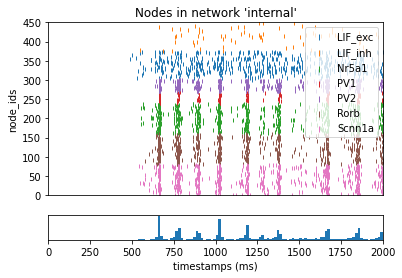

In [9]:
_ = plot_raster(config_file='bio_disconnected_sims/config.simulation_recreated.json', group_by='model_name')

### "Replay" Options for Selecting Subnets 

#### filtering by source/target properties

By default the `replay_spikes` input module will resimulate all the possible synapses in the `edges` files. However sometimes we may only want to replay subsets of recurrent synapses. To do so we can use the optional arguments `source_node_set` and/or `target_node_set` to filter out a smaller subset of synapses.

For example, we may want to see the synpatic contribution that the internal excitatory neurons had on the population of "Scnn1a" markered cells. We can modify the "**inputs**" section of the config file:

```json
{
  "inputs": {
    "replay_spikes": {
      "input_type": "replay_spikes",
      "module": "replay",
      "spikes_file": "$BASE_DIR/previous_results/spikes.baseline.h5",
      "source_node_set": {
        "population": "internal",
        "ei": "e"
      },
      "target_node_set": {
        "population": "internal",
        "model_name": "Scnn1a"
      },
      "edges": {
        "edges_file": "$NETWORK_DIR/internal_internal_edges.h5",
        "edge_types_file": "$NETWORK_DIR/internal_internal_edge_types.csv"
      }
    }
  }
}
```

* `source_node_set` will select only thoses synapses in the "internal" populaton of cells that have a originate from exciatory cells (defined by "`ei==e`")
* `target_node_set` will subsequently refine the subset of replayable connection to those synapses who synapse onto cells with with "`model_name==Scnn1a`"



In [10]:
bionet.reset()

conf = bionet.Config.from_json('bio_disconnected_sims/config.simulation_exc2scnn1a.json')
conf.build_env()

net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

2023-01-11 15:03:22,195 [INFO] Created log file
Mechanisms already loaded from path: /local1/workspace/bmtk/docs/tutorial/bio_disconnected_sims/components/mechanisms.  Aborting.
2023-01-11 15:03:22,210 [INFO] Building cells.
2023-01-11 15:06:16,657 [INFO] Building recurrent connections
2023-01-11 15:06:17,267 [INFO] Building replay connections "replay_spikes"
2023-01-11 15:06:18,419 [INFO] Running simulation for 2000.000 ms with the time step 0.100 ms
2023-01-11 15:06:18,420 [INFO] Starting timestep: 0 at t_sim: 0.000 ms
2023-01-11 15:06:18,421 [INFO] Block save every 5000 steps
2023-01-11 15:07:45,439 [INFO]     step:5000 t_sim:500.00 ms
2023-01-11 15:09:12,347 [INFO]     step:10000 t_sim:1000.00 ms
2023-01-11 15:10:40,169 [INFO]     step:15000 t_sim:1500.00 ms
2023-01-11 15:12:08,931 [INFO]     step:20000 t_sim:2000.00 ms
2023-01-11 15:12:08,955 [INFO] Simulation completed in 5.0 minutes, 50.54 seconds 


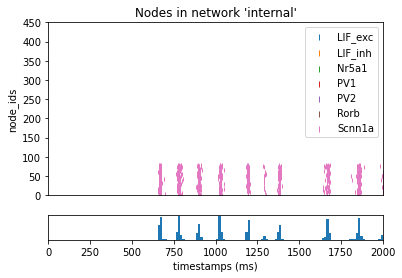

In [11]:
_ = plot_raster(config_file='bio_disconnected_sims/config.simulation_exc2scnn1a.json', group_by='model_name')

We may also want to filter only by the pre-synaptic source cell (or post-synaptic target). For example if we want select only recurrent synapses that target either one of our Pvalbumin cells, no matter the source-cell, we can use the following option:

```json
{
  "inputs": {
    "replay_spikes": {
      "input_type": "replay_spikes",
      "module": "replay",
      "spikes_file": "$BASE_DIR/previous_results/spikes.h5",
      "target_node_set": {
        "population": "internal",
        "model_name": ["PV1", "PV2"]
      },
      "edges": {
        "edges_file": "$NETWORK_DIR/internal_internal_edges.h5",
        "edge_types_file": "$NETWORK_DIR/internal_internal_edge_types.csv"
      }
    }
  }
} 
```

In [12]:
bionet.reset()

conf = bionet.Config.from_json('bio_disconnected_sims/config.simulation_pvalb.json')
conf.build_env()

net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

2023-01-11 15:12:09,279 [INFO] Created log file
Mechanisms already loaded from path: /local1/workspace/bmtk/docs/tutorial/bio_disconnected_sims/components/mechanisms.  Aborting.
2023-01-11 15:12:09,294 [INFO] Building cells.
2023-01-11 15:15:39,650 [INFO] Building recurrent connections
2023-01-11 15:15:40,376 [INFO] Building replay connections "replay_spikes"
2023-01-11 15:15:41,595 [INFO] Running simulation for 2000.000 ms with the time step 0.100 ms
2023-01-11 15:15:41,596 [INFO] Starting timestep: 0 at t_sim: 0.000 ms
2023-01-11 15:15:41,597 [INFO] Block save every 5000 steps
2023-01-11 15:16:55,998 [INFO]     step:5000 t_sim:500.00 ms
2023-01-11 15:18:09,830 [INFO]     step:10000 t_sim:1000.00 ms
2023-01-11 15:19:23,905 [INFO]     step:15000 t_sim:1500.00 ms
2023-01-11 15:20:38,985 [INFO]     step:20000 t_sim:2000.00 ms
2023-01-11 15:20:39,008 [INFO] Simulation completed in 4.0 minutes, 57.41 seconds 


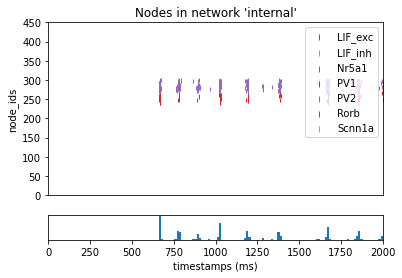

In [13]:
_ = plot_raster(config_file='bio_disconnected_sims/config.simulation_pvalb.json', group_by='model_name')

#### Selecting Cells by their node-id

If you have a list of specific cells identified by their node_id's you can pass in a list 

```json
{
  "inputs": {
    "replay_spikes": {
      "input_type": "replay_spikes",
      "module": "replay",
      "spikes_file": "$PREV_RESULTS_DIR/spikes.baseline.h5",
      "source_node_set": {
        "population": "internal",
        "node_id": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
      },
      "target_node_set": {
        "population": "internal",
        "node_id": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
      },
      "edges": {
        "edges_file": "$NETWORK_DIR/internal_internal_edges.h5",
        "edge_types_file": "$NETWORK_DIR/internal_internal_edge_types.csv"
      }
    }
  }
}
```

#### Using multiple edges/subnets

If you have a simulation that incorpates multple networks and/or need to run multiple subpopulations of synapses you can use the module more than once in the same configuration json.

```json
{
  "inputs": {
    "replay_edges_1": {
      "input_type": "replay_spikes",
      "module": "replay",
      ...
    }
    "replay_edges_2": {
      "input_type": "replay_spikes",
      "module": "replay",
      ...
    }
  }
}
```